In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from metrics import get_smoothed_mean_log_accuracy_ratio
import shap

In [4]:
X = pd.read_csv('resources/features.tsv',sep='\t')
Y = pd.read_csv('resources/validate_answers.tsv',sep='\t')
X = X.drop(['publishers','user_ids'], axis=1)

In [5]:
X = X[['p1',
       'remaining_time_to_next_ad',
       'delay',
       'cpm',
       'p2',
       'avg_session_duration',
       'history_cpm_mean',
       'adv_shown_freq']]

In [6]:
X

,p1,remaining_time_to_next_ad,delay,cpm,p2,avg_session_duration,history_cpm_mean,adv_shown_freq
0,-0.942728,-0.431918,-0.048882,0.513173,-0.993429,0.031297,-0.213110,-0.091844
1,-0.942728,-0.579641,-0.753012,1.333189,-0.993429,1.405716,-0.360443,3.411903
2,1.060135,-0.579641,-0.642250,-0.823809,0.825614,0.243083,-0.168024,0.209669
3,1.040478,-0.579641,-0.151733,0.691437,-0.993429,-0.043422,-0.185546,0.128124
4,1.291095,1.056681,1.082473,0.887528,-0.993429,-0.080610,0.043465,-0.563899
...,...,...,...,...,...,...,...,...
1003,-0.942728,-0.579641,-0.333699,-0.315756,0.971592,-0.038502,-0.255475,-0.167070
1004,-0.942728,-0.579641,-0.768836,-0.645545,1.325615,0.314428,-0.259162,-0.058252
1005,-0.942728,-0.579641,-0.760924,-0.360322,1.039542,1.060403,-0.383190,2.126062
1006,0.815684,0.931554,1.074561,-0.217711,1.345042,0.060473,-0.190716,-0.391586


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=142)

scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=np.number).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [9]:
from metrics import get_smoothed_mean_log_accuracy_ratio, get_smoothed_log_mape_column_value
from sklearn.metrics import make_scorer

def get_metric_for_ndarray(y_true, y_predicted):
    ans = get_smoothed_mean_log_accuracy_ratio(
        pd.DataFrame((y_true>0) * y_true, columns=Y.columns),
        pd.DataFrame((y_predicted>0) * y_predicted, columns=Y.columns)
    )
    return ans

def get_metric_for_one(y_true, y_predicted):
    return get_smoothed_log_mape_column_value((y_predicted>0)*y_predicted, (y_true>0)*y_true, 0.005)

Попробуем разные параметры

In [ ]:
# Определяем возможные значения параметров
params_grid = {
    'n_estimators': [700, 300, 500],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [ 4, 8, 10],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'bootstrap': [True]
}

In [55]:


rf = RandomForestRegressor(random_state=42)

model = GridSearchCV(rf,
                     params_grid,
                     scoring = make_scorer(get_metric_for_ndarray, greater_is_better=False),
                     cv=5, verbose=4, n_jobs=-1)

random_search = RandomizedSearchCV(rf, params_grid, n_iter=1000, scoring = make_scorer(get_metric_for_ndarray, greater_is_better=False), cv=5, verbose=2, n_jobs=-1)

In [43]:
random_search.fit(X_train, y_train.values)

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Лучшие параметры: {'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None, 'criterion': 'absolute_error', 'bootstrap': True}


In [47]:
print(f'Best score: {random_search.best_score_}')

Best score: -35.635999999999996


In [45]:
train_predictions = pd.DataFrame(random_search.best_estimator_.predict(X_train), columns=y_train.columns).clip(0)
test_predictions = pd.DataFrame(random_search.best_estimator_.predict(X_test), columns=y_train.columns).clip(0)

In [46]:
print(f'Train metric: {get_smoothed_mean_log_accuracy_ratio(y_train.reset_index(drop=True), train_predictions)}')
print(f'Test metric: {get_metric_for_ndarray(y_test.reset_index(drop=True), test_predictions)}')

Train metric: 21.25
Test metric: 32.43


In [93]:
import time
rf = RandomForestRegressor(n_estimators=300, min_samples_split=5, min_samples_leaf=4, min_impurity_decrease=0.0, max_leaf_nodes=None, max_features=None, max_depth=10, criterion='absolute_error', bootstrap=True ,random_state=42)
rf.fit(X_train, y_train.values)

start_time = time.perf_counter()
rf.predict(X_test)
end_time = time.perf_counter()

# Вычисление времени исполнения
execution_time = end_time - start_time
print(f"Время исполнения: {execution_time} секунд")



test_predictions = pd.DataFrame(rf.predict(X_test), columns=y_train.columns).clip(0)
print(f'Test metric: {get_metric_for_ndarray(y_test.reset_index(drop=True), test_predictions)}')

Время исполнения: 0.0075634999957401305 секунд
Test metric: 32.72


GPU

In [56]:
params_grid_xgboost = {
    'n_estimators': [90, 100, 120],
    'learning_rate': [0.09, 0.1],
    'max_depth': [4, 7]
}

In [57]:
from xgboost import XGBRegressor

model_gpu = XGBRegressor(device='cuda', random_state=42)
grid_search_xgb = GridSearchCV(model_gpu, params_grid_xgboost, scoring = make_scorer(get_metric_for_ndarray, greater_is_better=False), cv=5, verbose=2)



In [58]:
grid_search_xgb.fit(X_train, y_train.values)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...learning_rate=0.09, max_depth=4, n_estimators=90; total time=   0.3s
[CV] END ...learning_rate=0.09, max_depth=4, n_estimators=90; total time=   0.3s
[CV] END ...learning_rate=0.09, max_depth=4, n_estimators=90; total time=   0.3s
[CV] END ...learning_rate=0.09, max_depth=4, n_estimators=90; total time=   0.3s
[CV] END ...learning_rate=0.09, max_depth=4, n_estimators=90; total time=   0.3s
[CV] END ..learning_rate=0.09, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.09, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.09, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.09, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.09, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.09, max_depth=4, n_estimators=120; total time=   0.4s
[CV] END ..learning_rate=0.09, max_depth=4, n_es

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.09, 0.1], 'max_depth': [4, 7],
                         'n_estimators': [90, 100, 120]},
             scoring=make_scorer(get_metric_for_ndarray, greater_is_better=False),
             verbose=2)

In [60]:
print("Лучшие параметры:", grid_search_xgb.best_params_)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [59]:
print(f'Best score: {grid_search_xgb.best_score_}')
train_predictions = pd.DataFrame(grid_search_xgb.best_estimator_.predict(X_train), columns=y_train.columns).clip(0)
test_predictions = pd.DataFrame(grid_search_xgb.best_estimator_.predict(X_test), columns=y_train.columns).clip(0)
print(f'Train metric: {get_smoothed_mean_log_accuracy_ratio(y_train.reset_index(drop=True), train_predictions)}')
print(f'Test metric: {get_metric_for_ndarray(y_test.reset_index(drop=True), test_predictions)}')

Best score: -35.45
Train metric: 5.18
Test metric: 29.88


In [95]:
import time

model = XGBRegressor(device='cpu', learning_rate=0.1, max_depth=7, n_estimators=100, random_state=42)

model.fit(X_train, y_train.values)

start_time = time.time()
test_predictions = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Время исполнения: {execution_time} секунд")
test_predictions = pd.DataFrame(model.predict(X_test), columns=y_train.columns).clip(0)
print(f'Test metric: {get_metric_for_ndarray(y_test.reset_index(drop=True), test_predictions)}')

Время исполнения: 0.0025091171264648438 секунд
Test metric: 29.88


Сохранение модели

In [96]:
import joblib
joblib.dump(model, "server/model.pkl")



['server/model.pkl']

In [2]:
from tune_sklearn import TuneSearchCV
from ray.tune.search.skopt import SkOptSearch

%pip install
tune_search = TuneSearchCV(model, param_distributions=params_grid, scoring = make_scorer(get_metric_for_ndarray, greater_is_better=False), cv=5, verbose=2, n_jobs=-1, early_stopping=True, search_optimization='bayesian', use_gpu=True)

ModuleNotFoundError: No module named 'ray.tune.search.skopt'

In [ ]:
# train_model_predictions = np.array([
#     model1.predict(X_train),
#     model2.predict(X_train),
#     model3.predict(X_train)
# ])


# train_predictions = pd.DataFrame(train_model_predictions.T, columns=y_train.columns)

In [ ]:
# test_model_predictions = np.array([
#     model1.predict(X_test),
#     model2.predict(X_test),
#     model3.predict(X_test)
# ])

# test_predictions = pd.DataFrame(test_model_predictions.T, columns=y_train.columns)

In [139]:
train_predictions = pd.DataFrame(model.best_estimator_.predict(X_train), columns=y_train.columns).clip(0)
test_predictions = pd.DataFrame(model.best_estimator_.predict(X_test), columns=y_train.columns).clip(0)

In [140]:
print(f'Train metric: {get_smoothed_mean_log_accuracy_ratio(y_train.reset_index(drop=True), train_predictions)}')
print(f'Test metric: {get_metric_for_ndarray(y_test.reset_index(drop=True), test_predictions)}')

Train metric: 13.63
Test metric: 30.73


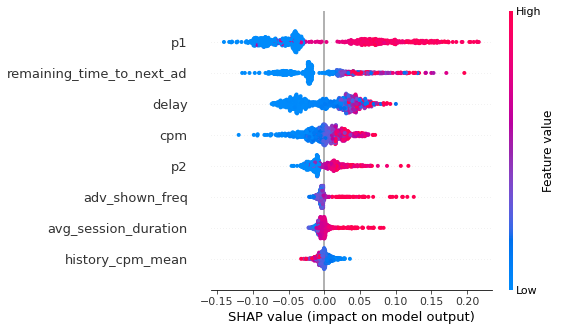

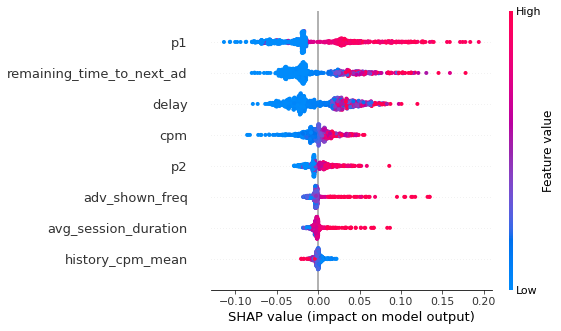

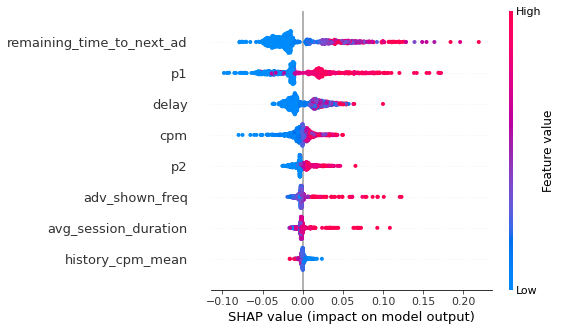

In [ ]:
# shap_test1 = shap.TreeExplainer(model1).shap_values(X_train, y_train['at_least_one'])
# shap.summary_plot(shap_test1, X_train, max_display=69)

# shap_test2 = shap.TreeExplainer(model2).shap_values(X_train, y_train['at_least_two'])
# shap.summary_plot(shap_test2, X_train, max_display=69)

# shap_test3 = shap.TreeExplainer(model3).shap_values(X_train, y_train['at_least_three'])
# shap.summary_plot(shap_test3, X_train, max_display=69)